##Loader

In [ ]:
!pip install latextable
!pip install names
!pip install num2words

  Created wheel for latextable: filename=latextable-0.2.1-py3-none-any.whl size=6243 sha256=be2853e4ab84a8c7ab04888b22c598cebbfc1d30668b1fec528c6194b1b8ca29
  Stored in directory: /root/.cache/pip/wheels/51/dc/99/540a81a40d112def87a9a200851a58d1ed6a866cfab4e93e56
Successfully built latextable
     |████████████████████████████████| 789 kB 5.1 MB/s 
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803699 sha256=af35b08df401268075c477817184191b355308fe723a30e07a319a31e525a1ac
  Stored in directory: /root/.cache/pip/wheels/05/ea/68/92f6b0669e478af9b7c3c524520d03050089e034edcc775c2b
Successfully built names
     |████████████████████████████████| 101 kB 3.3 MB/s 


In [ ]:
import random
from random import randint, choice, sample

import latextable
from texttable import Texttable

from sympy import *

variables = 'a b c d m n p q r s t w x y'
variables = symbols(variables, real=True)
variables += (Symbol('z'),)
a,b,c,d,m,n,p,q,r,s,t,w,x,y,z = variables

###Functions and sequences

In [ ]:
class LinFunc():
    """
    Represent a linear function.

    Attributes
    ----------
        slope : number (int, float, or Rational)
        intercept : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, slope, pt, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from slope and y-intercept.

        Parameters
        ----------
            slope : number (int, float, or Rational)
            pt : number or list
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """
        
        self.slope, pt = sympify([slope, pt])
        
        self.intercept = pt[1] - pt[0]*self.slope if type(pt)==list else pt
        self.expr = self.slope*variable + self.intercept

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted slope-intercept form."""
        
        if self.slope in [0,1]:
            slopeInt = ''
        elif self.slope == -1:
            slopeInt = '-'
        else:
            slopeInt = latexify(self.slope, self.precision)
        slopeInt += latex(self.variable) if self.slope!=0 else '' 
        
        intercept = latexify(self.intercept, self.precision)
        if self.intercept>0 and self.slope!=0:
            slopeInt += ' + '
        if self.intercept!=0 or self.slope==0:
            slopeInt += intercept
            
        return slopeInt
    
    @classmethod
    def fromPts(cls, pt1, pt2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct linear function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2 = sympify([pt1, pt2])
        
        slope = (pt2[1] - pt1[1])/(pt2[0] - pt1[0])
        
        if pt1[0]==0:
            return cls(slope, pt1[1], variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(slope, pt2[1], variable, label, domain, precision)
        else:
            return cls(slope, pt1, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        if self.slope == 0:
            return self.domain if output==self.intercept else None
        else:
            return (sympify(output)-self.intercept)/self.slope

    def getSlopeInt(self, notation='func'):
        """Return LaTeX formatted slope-intercept form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    def getPtSlope(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-slope form.
        
        Parameters
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
            notation : string, default='func'
                LHS of equality, default returns function notation.
        """

        pt = sympify(pt)
        if type(pt)!=list:
            pt = [pt] + [self.subs(pt)]
        
        ptTex = latexify(pt, self.precision)
        
        if self.slope in [0,1]:
            ptSlope = ''
        elif self.slope == -1:
            ptSlope = '-'
        else:
            ptSlope = latexify(self.slope, self.precision)
            
        if self.slope!=0:
            ptSlope += r'\left(' + latex(self.variable)
            ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            ptSlope += r'\right)'
        
        if pt[1]>0 and self.slope!=0:
            ptSlope += ' + '
        if pt[1]!=0 or self.slope==0:
            ptSlope += ptTex[1]
        
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptSlope
        else:
            return notation + '=' + ptSlope
            
    def getStdForm(self, notation='y', mult=1):
        if self.slope == 0:
            mult = nsimplify(self.intercept).q
        elif self.intercept == 0:
            mult = nsimplify(self.slope).q
        else:
            mult *= abs(lcm(nsimplify(self.slope).q, nsimplify(self.intercept).q))
        mult = -mult if self.slope<=0 else mult
        
        stdForm = latex(nsimplify(mult*self.slope*self.variable - mult)) + notation
        stdForm += '=' + latex(nsimplify(-mult*self.intercept))
        
        return stdForm
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
            vertical : bool, default=True
            labels : list, default=None
                Defaults are independent variable and function notation.
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class ExpFunc():
    """
    Represent an exponential function.

    Attributes
    ----------
        base : number (int, float, or Rational)
        intercept : number
        shift : number
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, base, pt, shift=0, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from base, point/y-int, and vertical shift.

        Parameters
        ----------
            base : number (int, float, or Rational)
            intercept : number
            shift : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """

        self.base, pt, self.shift = sympify([base, pt, shift])

        self.lead = (pt[1]-self.shift)/Pow(self.base,pt[0]) if type(pt)==list else pt-self.shift
        self.expr = self.lead*(self.base**variable) + self.shift

        self.intercept = self.lead + self.shift
        
        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted standard form."""

        if self.lead == 1:
            string = ''
        elif self.lead == -1:
            string = '-'
        else:
            string = latexify(self.lead, self.precision)
            if type(self.base)==Integer and self.base>0:
                string += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            string += fr'({base})^{self.variable}'
        else:            
            string += latex(self.base**self.variable)

        if self.shift != 0:
            string += ('+' + latexify(self.shift)) if self.shift>0 else latexify(self.shift)
            
        return string
    
    @classmethod
    def fromPts(cls, pt1, pt2, shift=0, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct exponential function object from two ordered pairs.

        Parameters
        ----------
            pt1, pt2 : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """
        
        pt1, pt2, shift = sympify([pt1, pt2, shift])
        
        base = Pow((pt2[1]-shift)/(pt1[1]-shift), 1/(pt2[0]-pt1[0]))
        
        if pt1[0]==0:
            return cls(base, pt1[1], shift, variable, label, domain, precision)
        elif pt2[0]==0:
            return cls(base, pt2[1], shift, variable, label, domain, precision)
        else:
            return cls(base, pt1, shift, variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        """Return preimage of given output."""
        
        soln = log((sympify(output)-self.shift)/self.lead, self.base)

        return soln if soln in S.Reals else None
    
    def getStdForm(self, notation='func'):
        """Return LaTeX formatted standard form."""

        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)
    
    def getBaseInt(self, notation='func'):
        """Return LaTeX formatted base-intercept form."""

        return self.getStdForm(notation)

    def getPtBase(self, pt=1, notation='func'):
        """
        Return LaTeX formatted point-base form.
        
        Parameter
        ---------
            pt : number or list/tuple
                Independent variable value or ordered pair.
            notation : string, default='func'
                LHS of equality, default returns function notation.
        """

        pt = sympify(pt)
        pt, lead = [pt, self.subs(pt)-self.shift] if type(pt) not in [list,tuple] else [pt[0], pt[1]-self.shift]
         
        if lead == 1:
            ptBase = ''
        elif lead == -1:
            ptBase = '-'
        else:
            ptBase = latexify(lead, self.precision)
            if type(self.base)==Integer and self.base>0:
                ptBase += r' \cdot '
            
        if type(self.base)==Float or abs(self.base.q)>999:
            base = latexify(self.base, self.precision)
            ptBase += fr'({base})^' + r'{' + latex(self.variable-pt) + r'}'
        else:
            ptBase += latex(self.base**(self.variable - pt))
        
        if self.shift != 0:
            ptBase += ('+' + latexify(self.shift)) if self.shift>0 else latexify(self.shift)
            
        if notation == 'func':
            return fr'{self.label}({self.variable}) = ' + ptBase
        else:
            return notation + '=' + ptBase
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
            vertical : bool, default=True
            labels : list, default=None
                Defaults are independent variable and function notation.
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class QuadFunc():
    """
    Represent a quadratic function.

    Attributes
    ----------
        aa : number (int, float, or Rational)
        bb : number
        cc : number
        
        variable : sympy symbol, default=x
        label : str, default='f'
        expr : sympy expression
        domain : sympy set, default=S.Reals
        precision : int, default=2
    """

    def __init__(self, aa, bb, cc, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from coefficients.

        Parameters
        ----------
            aa : number (int, float, or Rational)
            bb : number
            cc : number
            variable : sympy symbol, default=x
            label : str, default='f'
            domain : sympy set, default=S.Reals
            precision : int, default=2
        """
        
        self.aa, self.bb, self.cc = sympify([aa, bb, cc])
        
        self.expr = self.aa*variable**2 + self.bb*variable + self.cc

        self.variable = variable
        self.label = label
        self.domain = domain
        self.precision = precision
    
    def __str__(self):
        """Return LaTeX formatted standard form."""
        
        if self.aa in [0,1]:
            stdForm = ''
        elif self.aa == -1:
            stdForm = '-'
        else:
            stdForm = latexify(self.aa, self.precision)
        stdForm += latex(self.variable**2) if self.aa!=0 else '' 
        
        bb = latexify(self.bb, self.precision)
        if self.bb>0 and self.aa!=0:
            stdForm += ' + '
        if self.bb == -1:
            stdForm += ' - '
        elif self.bb not in [0,1]:
            stdForm += bb
        stdForm += latex(self.variable) if self.bb!=0 else ''
            
        cc = latexify(self.cc, self.precision)
        if self.cc>0 and (self.aa!=0 or self.bb!=0):
            stdForm += ' + '
        if self.cc!=0 or (self.aa==0 and self.bb==0):
            stdForm += cc
            
        return stdForm
    
    @classmethod
    def fromVertex(cls, aa, vertex, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and vertex.

        Parameters
        ----------
            aa : number
            vertex : list or tuple
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, hh, kk = sympify([aa, *vertex])
        
        return cls(aa, -2*aa*hh, a*hh**2+kk, variable, label, domain, precision)
    
    @classmethod
    def fromRoots(cls, aa, root1, root2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and roots.

        Parameters
        ----------
            aa : number
            root1, root2 : numbers
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, root1, root2 = sympify([aa, root1, root2])
        
        return cls(aa, -aa*(root1+root2), a*root1*root2, variable, label, domain, precision)
    
    @classmethod
    def from2Pts(cls, aa, pt1, pt2, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from stretch factor (a) and 2 points.

        Parameters
        ----------
            aa : number
            pt1, pt2 : lists or tuples
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        aa, pt1, pt2 = sympify([aa, pt1, pt2])

        expr = aa*x**2 + b*x + c
        coeffs = solve([expr.subs(x,pt1[0])-pt1[1], expr.subs(x,pt2[0])-pt2[1]])
        
        return cls(aa, coeffs[b], coeffs[c], variable, label, domain, precision)
    
    @classmethod
    def from3Pts(cls, pt1, pt2, pt3, variable=x, label='f', domain=S.Reals, precision=2):
        """
        Construct quadratic function object from 3 points.

        Parameters
        ----------
            pt1, pt2, pt3 : lists or tuples
            variable : sympy symbol, default=x
            label : str, default='f'
        """

        pt1, pt2, pt3 = sympify([pt1, pt2, pt3])

        expr = a*x**2 + b*x + c
        coeffs = solve([expr.subs(x,pt1[0])-pt1[1], expr.subs(x,pt2[0])-pt2[1], expr.subs(x,pt3[0])-pt3[1]])
        
        return cls(coeffs[a], coeffs[b], coeffs[c], variable, label, domain, precision)

    def subs(self, input):
        """Return evaluation of function at input."""

        return self.expr.subs(self.variable, sympify(input))

    def subSet(self, preimage):
        """Return image of set."""

        return ImageSet(Lambda(self.variable, self.expr), preimage).intersect(S.Reals)

    def getRange(self):
        """Return range of function."""

        return self.subSet(self.domain)
        
    def solve(self, output):
        return solve(self.expr.subs(self.variable,z)-output)

    def getVertex(self):
        hh = -Rational(self.bb,2*self.aa)
        return [hh, self.subs(hh)]

    def getRoots(self):
        return self.solve(0)

    def getStdForm(self, notation='func'):
        """Return LaTeX formatted standard form."""

        if notation == 'func':
            return f'{self.label}({self.variable}) = ' + str(self)
        else:
            return notation + '=' + str(self)

    # def getPtSlope(self, pt=1, notation='func'):
        # """
        # Return LaTeX formatted point-slope form.
        
        # Parameter
        # ---------
            # pt : number or list/tuple
                # Independent variable value or ordered pair.
        # """

        # pt = sympify(pt)
        # if type(pt)!=list:
            # pt = [pt] + [self.subs(pt)]
        
        # ptTex = latexify(pt, self.precision)
        
        # if self.slope in [0,1]:
            # ptSlope = ''
        # elif self.slope == -1:
            # ptSlope = '-'
        # else:
            # ptSlope = latexify(self.slope, self.precision)
            
        # if self.slope!=0:
            # ptSlope += r'\left(' + latex(self.variable)
            # ptSlope += '+' + ptTex[0][1:] if pt[0]<0 else '-' + ptTex[0]
            # ptSlope += r'\right)'
        
        # if pt[1]>0 and self.slope!=0:
            # ptSlope += ' + '
        # if pt[1]!=0 or self.slope==0:
            # ptSlope += ptTex[1]
        
        # if notation == 'func':
            # return fr'{self.label}({self.variable}) = ' + ptSlope
        # else:
            # return notation + '=' + ptSlope
        
    def getTable(self, nums, vals=True, vertical=True, labels=None):
        """
        Return LaTeX formatted table at given positions with or without blanks.
        
        Parameters
        ----------
            nums : list of ints
            vals : bool or list of bools or nonempty/empty strings ('')
        """
        
        vals = len(nums)*[vals] if type(vals)==bool else vals
        images = [signify(latexify(self.subs(jj), self.precision)) for jj in nums]
        images = [jj if vals[count] else r'\phantom{' + jj + r'}' for count,jj in enumerate(images)]
        
        nums = sympify(nums)
        nums = [signify(latexify(jj, self.precision)) for jj in nums]
        
        if labels == None:
            labels = [signify(str(self.variable)), fr'${self.label}({self.variable})$']
        if vertical:
            header = labels
            rows = list(zip(nums,images))
        else:
            header = [labels[0]] + list(nums)
            rows = [[labels[1]] + images]
        
        return tableGenerator(header, rows)

In [ ]:
class ArithSeq(LinFunc):
    """
    Represent an arithmetic sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common difference.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : LinFunc
        terms : dict
    """

    def __init__(self, common, pt, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct arithmetic sequence object from common difference and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common difference.
            pt : number or list
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, variable, label, domain, precision)
        
        self.common = self.slope
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return dict of terms."""

        minNum = min(self.terms.keys())
        maxNum = max(self.terms.keys())
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1] + self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = self.terms[jj+1] - self.common
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getSlopeInt() if term==0 else self.getPtSlope(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {self.label}(n-1)'
        if self.common >= 0:
            recursive += ' + ' + latexify(self.common, self.precision)
        else:
            recursive += latexify(self.common, self.precision)
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'

class GeoSeq(ExpFunc):
    """
    Represent a geometric sequence.

    Attributes
    ----------
        common : number (int, float, or Rational)
            Common ratio.
        start : number
            First term (a_1 or f(1)).
        label : str, default='f'
        func : ExpFunc
        terms : dict
    """

    def __init__(self, common, pt, shift=0, variable=n, label='f', domain=S.Integers, precision=2):
        """
        Construct geometric sequence object from common ratio and first term.

        Parameters
        ----------
            common : number (int, float, or Rational)
                Common ratio.
            start : number
                First term (a_1 or f(1)).
            label : str, default='f'
        """
        
        super().__init__(common, pt, shift, variable, label, domain, precision)

        self.common = self.base
        self.start = self.subs(1)
        self.terms = {0: self.intercept, 1: self.start, 2: self.subs(2), 3: self.subs(3)}
    
    def findTerm(self, num: int):
        """Return term at given index."""

        if num in self.terms.keys():
            return self.terms[num]
        else:
            return self.subs(num)
    
    def findTermNum(self, end):
        """Return index of given term."""

        if end in self.terms.values():
            return list(self.terms.keys())[list(self.terms.values()).index(end)]
        else:
            return self.solve(end)
    
    def getTerms(self, num: int, startnum=0):
        """Return list of terms."""

        minNum = int(min(self.terms.keys()))
        maxNum = int(max(self.terms.keys()))
        if num > maxNum:
            for jj in range(maxNum+1, num+1):
                self.terms[jj] = self.terms[jj-1]*self.common
        if startnum < minNum:
            for jj in range(minNum-1, startnum-1, -1):
                self.terms[jj] = Rational(self.terms[jj+1],self.common)
        return self.terms
    
    def getExplicit(self, term=1):
        """
        Return LaTeX formatted explicit representation.
        
        Parameter
        ---------
            term : number or list/tuple
                Index of term or ordered pair.
        """

        return self.getBaseInt() if term==0 else self.getPtBase(term)
    
    def getRecursive(self, startnum=1):
        """
        Return LaTeX formatted recursive representation.

        Parameter
        ---------
            startnum : int
        """

        term = self.findTerm(startnum) if startnum!=1 else self.start
        recursive = fr'{self.label}(n) = {latexify(self.common, self.precision)}\cdot {self.label}(n-1)'
        recursive += fr',\quad {self.label}({startnum}) = {latexify(term, self.precision)}'
        return recursive
        
    def getSeqStr(self, nums=[1,2,3]):
        """
        Return LaTeX formatted list at given positions with or without blanks.
        
        Parameter
        ---------
            nums : list of ints or empty strings ('')
        """
        
        blank = r'\underline{\hspace{4mm}}'
        result = [latexify(self.findTerm(jj), self.precision) if type(jj)==int else blank for jj in nums]
        
        return (', ').join(result) + r', \ldots'


In [ ]:
def getSeqAnswer(seq, prob='common', blanks=False, expr="latex", numTerms=6):
    if expr=="latex":
        answer = []
        if prob in ['common','all'] :
            answer.append('d = ' if type(seq)==ArithSeq else 'r = ')
            answer[0] += latex(seq.common)
        if prob in ['explicit','all']:
            answer.append(seq.getExplicit() + r' \quad\text{or}\quad ' + seq.getExplicit(0))
        if prob in ['recursive','all']:
            answer.append(seq.getRecursive() + r' \quad\text{or}\quad ' + seq.getRecursive(0))
        
        if blanks:
            answer.append(seq.getSeqStr(range(1,numTerms+1)))
        
        return answer if len(answer)>1 else answer[0]
    else:
        seq.getTerms(numTerms)
        answer = seq
        return answer

###Generators and printers

In [ ]:
def chooseFloat(package):
  floatA = random.choice(package)
  return floatA

def getFloat(min=-10,max=10,roundby=2):
  return round(random.uniform(min, max), roundby)

def getInt(min= -4, max = 4, exclude=[0]):
  intA = random.choice([x for x in range(min,max+1) if x not in exclude])
  return sympify(intA)

def getVar(exclude=None):
  return random.choice([vrbl for vrbl in variables if vrbl not in exclude])

def getFrac(denommin= -4, denommax= 4, numermin = 1, numbermax = 4 , exclude = 0):# exclude 1 in denom later
  top = random.choice([x for x in range(numermin,numbermax+1) if x != exclude])
  bot = random.choice([x for x in range(denommin,denommax+1) if x != exclude])
  return latex(simplify(Rational(top,bot),evaluate=False))

"""###Table"""

def tableGenerator(header, rows, cols_align=None, cols_valign=None, expr='latex', table_env=False, stretch=1.5):
    """
    Generate a table.

    Parameters
    ----------
        header : list or tuple
        rows : 2-dimensional array
        cols_align : list or tuple, default=None
            List of column alignments ('l','c', or 'r'); if ``None``, all set to 'c'.
        expr : str, default='latex'
            LaTeX formatted.
        table_env : boolean, default=True
            Enclose in floating table environment (\begin{table}...).

    Returns
    -------
        str
    """

    table = Texttable()
    if cols_align == None:
        cols_align = len(header)*['c']
    if cols_valign == None:
        cols_valign = len(header)*['m']
    table.set_cols_align(cols_align)
    table.set_cols_valign(cols_valign)
    table.add_rows([header] + rows)

    if expr == 'latex':
        table = latextable.draw_latex(table)
        if not table_env:
            table = table.replace('\\begin{table}\n','').replace('\n\\end{table}','')
        if stretch == 1:
            return table
        else:
            return r'{\renewcommand{\arraystretch}' + brackify(stretch) + table + r'}'
    else:
        return table.draw()
        
def makeInterval(string):
    if type(string)==Interval:
        return string
    left_open = (string[0]=='(')
    right_open = (string[-1]==')')
    start, end = sympify(string[1:-1].split(','))
    return Interval(start, end, left_open, right_open)

In [ ]:
def signify(data):
    if type(data)==list:
        return [signify(jj) for jj in data]
    else:
        return '$' + str(data) + '$'
    
def latexify(data, precision=2):
    if type(data)==list:
        return [latexify(num, precision) for num in data]
    elif type(data)==dict:
        return {k:latexify(v, precision) for k,v in data.items()}
    elif type(data) in [Integer,int]:
        return f'{int(data):,}'
    elif type(data) in [Float,float]:
        return f'{data:,.{precision}f}'
    elif type(data)==Rational and abs(data.q)>999:
        return f'{Float(data):,.{precision}f}'
    elif type(data)==Mul:
        a,b,c = Wild('a'),Wild('b'),Wild('c')
        data = data.match(a*b**c)
        data = data[a]*UnevaluatedExpr(real_root(data[b],data[c].q))**data[c].p
        return latex(data)
    elif isinstance(data, Set):
        return latex(data) if data.boundary.is_subset(Integers) else latex(N(data,precision+1))
    elif type(data)==str:
        return data
    else:
        return latex(data)

def brackify(data):
    return r'{' + str(data) + r'}'
        
def minipagify(left, right, vspace='0.25in'):
    string = '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += left + '\n\\end{minipage}\n'
    string += '\\begin{minipage}[t]{0.5\\textwidth}\n'
    string += right + '\n\\end{minipage}\n\n'
    string += f'\\vspace{brackify(vspace)}\n'
    return string

###Graphers

In [ ]:
def startGraph(xmin=-10,xmax=10,ymin=-10,ymax=10):
    xstart = 5*(xmin//5)
    ystart = 5*(ymin//5)
    xtick = brackify(f'{xstart},{xstart+5},...,{xmax+5}')
    ytick = brackify(f'{ystart},{ystart+5},...,{ymax+5}')

    tex = r'\begin{tikzpicture}\begin{axis}[mmt axis style,'
    tex += fr'xmin={xmin},xmax={xmax},xtick={xtick},ymin={ymin},ymax={ymax},ytick={ytick},]'
    return tex

def endGraph():
    return r'\end{axis}\end{tikzpicture}'

def emptyGraph(xmin=-10,xmax=10,ymin=-10,ymax=10):
    return startGraph(xmin,xmax,ymin,ymax) + endGraph()

def drawPt(pt, draw='black', fill='black', shape='circle', size='2pt'):
    return fr'\fill[draw={draw},fill={fill}] (axis cs: {pt[0]},{pt[1]}) {shape}({size});'

def drawScatter(pts, draw='black', fill='black', shape='', size='2pt'):
    """
    Return LaTeX to draw list of points on a graph.

    Parameters
    ----------
        pts : list
            List of coordinate pairs.
        draw : string, default='black'
            Color of mark boundaries.
        fill : string, default='black'
            Color of mark fills.
        shape : string, default=''
            Shape of marks, default='' gives circle.
                Other options include 'triangle','square','diamond,'star','otimes'.
        size : string, default='2pt'
    """

    pts = ' '.join([str(tuple(jj)) for jj in pts])
    return fr'\addplot[only marks,draw={draw},fill={fill},mark={shape}*,mark size={size}] coordinates {brackify(pts)};'
    
def drawLinear(expr,xmin,xmax,color='black',style='solid'):
    string = fr'\addplot[{style},domain={xmin}:{xmax}, color={color},]{brackify(expr)};'
    return string

def drawCurve(expr, inMin, inMax, LHS='y', color='black', style='solid', width='thick', label=None, fillName=None):
    """
    Return LaTeX to draw a curve on a graph.

    Parameters
    ----------
        expr : string or sympy expression
            Right-hand side of equation
        inMin : number
            Minimum value of independent variable.
        inMax : number
            Maximum value of independent variable.
        LHS : string, default='y'
            Left-hand side of equation.
        color : string, default='black'
        style : string, default='solid'
        width : string, default='thick'
        label : list or string, default=None
            If list, format as [<label>, <rel. pos.>, <angle>] where rel. pos.
                is relative position as a float in [0,1] and angle is given in degrees.
            If string, default rel. pos.=0.7 and default angle=45.
        fillName : string, default=None
            Name of curve used for fillbetween library (needed only for inequality graphers).
    """
    
    string = fr'\addplot[{color},{style},{width},domain={inMin}:{inMax},samples=100'
    string += r'] ' if fillName==None else fr',name path={fillName}] '

    variables = sympify(expr).free_symbols
    expr = str(expr).replace('**','^')

    if (variables=={x}) or (LHS in ['y',y]):        # Function of x
        string += brackify(expr)
    elif (variables=={y}) or (LHS in ['x',x]):      # Function of y
        expr = expr.replace('y','x')
        string += f'({brackify(expr)},{brackify(x)})'

    if label==None:
        return string + r';'
    else:
        if type(label) != list:
            label = [label, 0.7, 45]
        return string + fr' node[pos={label[1]},pin={label[2]}:{signify(label[0])}]' + r' {};'

def drawSlopeTri(pt1, pt2):
    string = fr'\draw[dashed] (axis cs: {pt1[0]},{pt1[1]}) -- (axis cs: {pt1[0]},{pt2[1]});'
    string += fr'\draw[dashed] (axis cs: {pt1[0]},{pt2[1]}) -- (axis cs: {pt2[0]},{pt2[1]});'
    return string

def shadeRegion(xmin, xmax, lower, upper, color='blue!30', shading='opacity=0.5'):
    domain = fr'domain={xmin}:{xmax}'
    string = fr'\addplot[{color},{shading}] fill between'
    string += fr'[of={lower} and {upper},soft clip={brackify(domain)}];'
    return string

###Word problems

In [ ]:
import names, pandas
from num2words import num2words

DIFF, RATIO, SEQ_1, SEQ_2, SEQ_3 = symbols('DIFF RATIO SEQ_1 SEQ_2 SEQ_3')
INTA, INTB, FLOATA, FLOATB = symbols('INTA INTB FLOATA FLOATB')

# Lin_probs = pandas.read_csv('Lin_probs.csv')
# Lin_probs = Lin_probs[['Question','Answer1','Answer2','Controller','In','Out']]

# Exp_probs = pandas.read_csv('Exp_probs.csv')
# Exp_probs = Exp_probs[['Question','Answer1','Answer2','Controller','In','Out']]

def getControls(controls):
    params = dict()

    for word in controls:
        word, range = word.split('=')
        range = range.replace('[','').replace(']','').split(',')
        mnm, mxm = sympify(range[:2])
        params[word] = getFloat(mnm,mxm) if type(mnm)==Float else getInt(mnm,mxm)

    return params

def getParam(word, params, kind):
    if word == 'LASTNAME':
        return names.get_last_name()
    elif word == 'FIRSTNAME':
        return names.get_first_name()
    elif word == 'FIRSTNAME_MALE':
        return names.get_first_name(gender='male')
    elif word == 'FIRSTNAME_FEMALE':
        return names.get_first_name(gender='female')
    elif word == 'SEQ_2':
        if kind == 'lin':
            return params['SEQ_1'] + params['DIFF']
        elif kind == 'exp':
            return params['SEQ_1']*params['RATIO']
    elif word == 'SEQ_3':
        if kind == 'lin':
            return 2*params['SEQ_2'] - params['SEQ_1']
        elif kind == 'exp':
            return params['SEQ_2']**2/params['SEQ_1']
    elif word == 'MULT_PHRASE':
        if 'RATIO' not in params.keys():
            params['RATIO'] = randint(2,5)
        phrase = 'twice' if params['RATIO']==2 else num2words(params['RATIO']) + ' times'
        return phrase
    elif word == 'GROWTH_PHRASE':
        growths = {2: 'doubles', 3: 'triples', 4: 'quadruples'}
        if 'RATIO' not in params.keys():
            params['RATIO'] = randint(2,5)
        if params['RATIO'] in growths.keys():
            phrase = growths[params['RATIO']]
        else:
            phrase = 'grows by a factor of ' + num2words(params['RATIO'])
        return phrase

def getWordValue(word, params, kind, string=True):
    symbol1 = ''
    symbol2 = ''
    if (not word[0].isalnum()) and word[0]!='(':
        symbol1 = '\\' + '$' if word[0] in ['$','£'] else word[0]
        word = word[1:]
    if (not word[-1].isalnum()) and word[-1]!=')':
        symbol2 = '\\' + word[-1] if word[-1]=='%' else word[-1]
        word = word[:-1]

    if '(' in word:
        word = sympify(word).subs(params.items())
    elif word.isnumeric():
        word = sympify(word)
    else:
        if word not in params.keys():
            params[word] = getParam(word, params, kind)
        word = params[word]
    
    return symbol1 + str(latexify(word)) + symbol2 if string else word

def makeWordProb(kind='lin', expr='latex'):
    if kind == 'lin':
        data = Lin_probs.loc[randint(0,len(Lin_probs)-1)]
    elif kind == 'exp':
        data = Exp_probs.loc[randint(0,len(Exp_probs)-1)]
    else:
        data = Neither_probs.loc[randint(0,len(Neither_probs)-1)]

    problem = data[0].split()
    solns = data[1:3].copy()
    controls = data[3].split()
    labels = list(data[4:6].values)

    params = getControls(controls)

    expressions = []
    for count,word in enumerate(problem):
        if word.isupper() and len(word)>2:
            if '(' in word:
                expressions.append([count,word])
            else:
                problem[count] = getWordValue(word, params, kind)
    for count,word in expressions:
        problem[count] = getWordValue(word, params, kind)
    
    for jj in [0,1]:
        solns[jj] = solns[jj].split(',')
        if len(solns[jj]) > 1:
            solns[jj] = [ getWordValue(solns[jj][0], params, kind, string=False), getWordValue(solns[jj][1], params, kind, string=False) ]
        else:
            solns[jj] = getWordValue(solns[jj][0], params, kind, string=False)

    return ' '.join(problem), solns, labels

## AGS1.2.7.1 - Fill In The Table

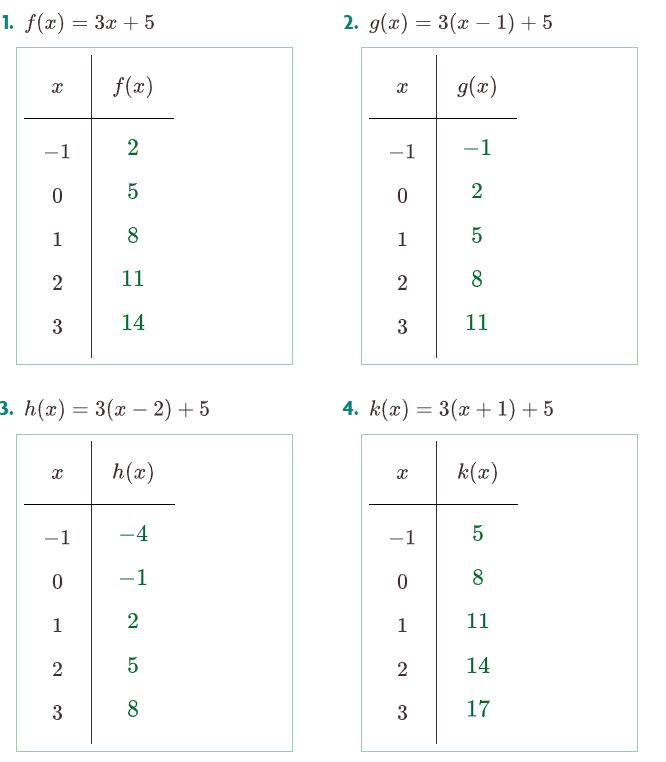

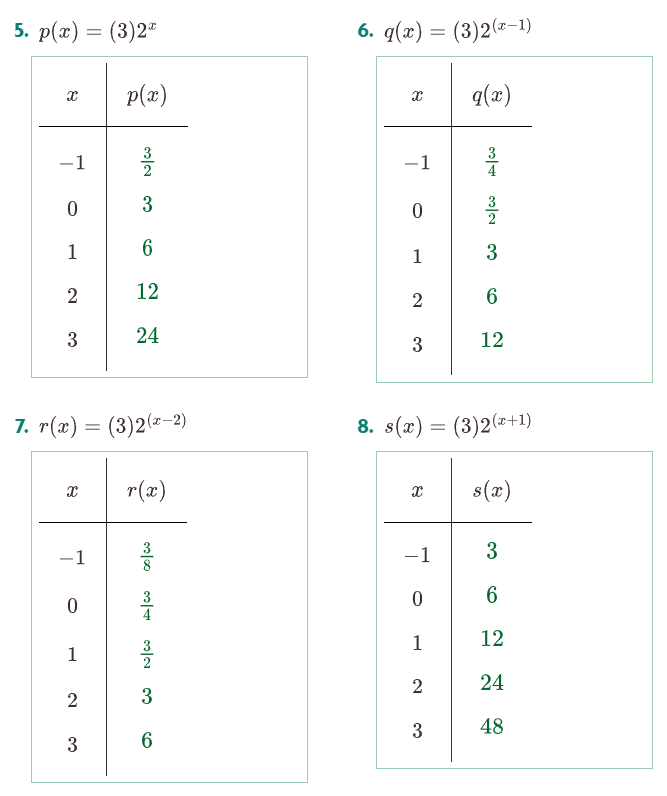

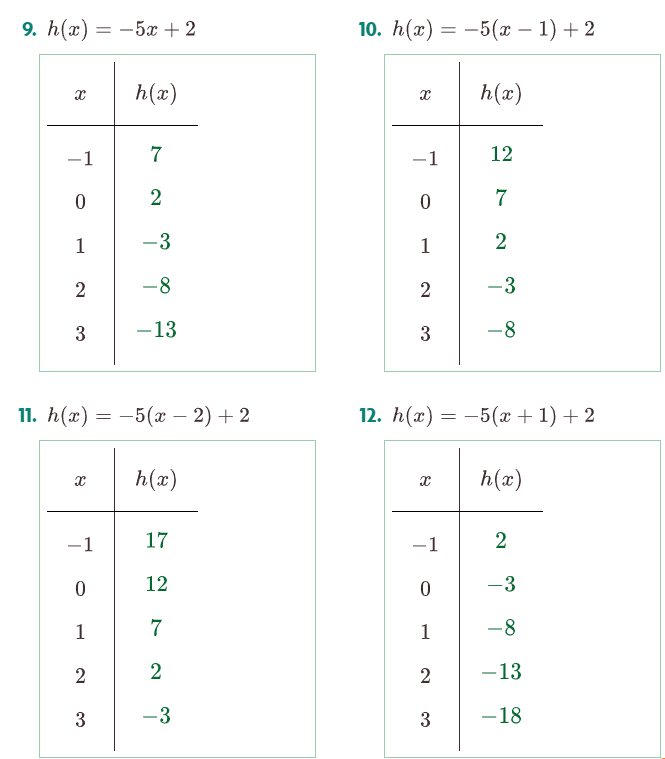

### instruction : Fill in the table of values for each function.
#### section 1
---
Case 1 - linear equation

- intA = [-5,5] 
- intB = [-5,5]

$$ f(x) = intA * x + intB$$

$$ f(x) = intA ( x - 1) + intB $$

$$ f(x) = intA ( x + 1) + intB $$

$$ f(x) = intA ( x - 2) + intB $$

- $$ f(x) = 3x + 5$$

| x | f(x) |
| :---: | :---: |
| -1 |  |
| 0 |  |
| 1 |  |
| 2 |  |
| 3 |  |

- $$ f(x) = 3(x - 1) + 5$$

| x | f(x) |
| :---: | :---: |
| -1 |  |
| 0 |  |
| 1 |  |
| 2 |  |
| 3 |  |

- $$ f(x) = 3(x - 2) + 5$$

| x | f(x) |
| :---: | :---: |
| -1 |  |
| 0 |  |
| 1 |  |
| 2 |  |
| 3 |  |

- $$ f(x) = 3(x + 1) + 5$$

| x | f(x) |
| :---: | :---: |
| -1 |  |
| 0 |  |
| 1 |  |
| 2 |  |
| 3 |  |


---
Case 2 - Geometric Equation

- intA = [-3,-2,2,3]
- intB = [ 1/2,1/3,2,3,4]

$$ f(x) = (intA)(intB)^{x}$$

$$ f(x) = (intA)(intB)^{x -1}$$

$$ f(x) = (intA)(intB)^{x + 1}$$

$$ f(x) = (intA)(intB)^{x - 2}$$

- $$ f(x) = (3)(2)^{x}$$

| x | f(x) |
| :---: | :---: |
| -1 |  |
| 0 |  |
| 1 |  |
| 2 |  |
| 3 |  |

- $$ f(x) = (3)(2)^{x - 1}$$

| x | f(x) |
| :---: | :---: |
| -1 |  |
| 0 |  |
| 1 |  |
| 2 |  |
| 3 |  |

- $$ f(x) = (3)(2)^{x + 1}$$

| x | f(x) |
| :---: | :---: |
| -1 |  |
| 0 |  |
| 1 |  |
| 2 |  |
| 3 |  |

- $$ f(x) = (3)(2)^{x - 2}$$

| x | f(x) |
| :---: | :---: |
| -1 |  |
| 0 |  |
| 1 |  |
| 2 |  |
| 3 |  |


In [ ]:
def FillInTheTable(option='exp', expr='latex'):
    header = ['$x$', '$f(x)$']
    rows = []

    if option == 'lin': # linear
        start = getInt(-5, 5)
        diff = getInt(-5, 5)
        seq = ArithSeq(diff, [1,start])
    if option == 'exp': # exponential
        start = choice([-3,-2,2,3])
        ratio = choice([Rational(1,2), Rational(1,3), 2,3,4])
        seq = GeoSeq(ratio, [1,start])

    terms = latexify(seq.getTerms(num=5, startnum=-2))
    for jj in range(-1, 4):
        rows.append([signify(str(jj)), r'\phantom' + brackify(signify(terms[jj]))])
    emptyTable = tableGenerator(header, rows, table_env=False)
    problems = []
    answers = []
    for case in [0,1,2,-1]:
        if option=='lin':
            func = LinFunc(diff,[case,start])
            func = func.getPtSlope(case) if case!=0 else func.getSlopeInt()
        else:
            func = ExpFunc(ratio,[case,start])
            func = func.getPtBase(case) if case!=0 else func.getBaseInt()
        problems.append([func, emptyTable])

        for jj in range(5):
            rows[jj][1] = signify(terms[jj-case])
        answers.append(tableGenerator(header, rows, table_env=False))

    if expr=='latex':
        problem = ''
        answer = ''
        for jj in range(4):
            if jj%2==0:
                problem += '\\vspace{0.25in}\n'
                answer += '\\vspace{0.25in}\n'
            problem += '\\begin{minipage}[t]{0.5\\textwidth}\n'
            problem += '$' + problems[jj][0] + '$ \n'
            problem += problems[jj][1] + '\n\\end{minipage}\n'
            answer += '\\begin{minipage}[t]{0.5\\textwidth}\n'
            answer += '$' + problems[jj][0] + '$ \n'
            answer += answers[jj] + '\n\\end{minipage}\n'
    else:
        problem = problems
        answer = answers

    return problem, answer
  

for i in range(1):
    problem, answer = FillInTheTable(option='exp')
    print(problem, answer)

\vspace{0.25in}
\begin{minipage}[t]{0.5\textwidth}
$f(x) = 3 \cdot 3^{x}$ 
{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\hline
			$x$ & $f(x)$ \\
			\hline
			$-1$ & \phantom{$\frac{1}{3}$} \\
			\hline
			$0$ & \phantom{$1$} \\
			\hline
			$1$ & \phantom{$3$} \\
			\hline
			$2$ & \phantom{$9$} \\
			\hline
			$3$ & \phantom{$27$} \\
			\hline
		\end{tabular}
	\end{center}}
\end{minipage}
\begin{minipage}[t]{0.5\textwidth}
$f(x) = 3 \cdot 3^{x - 1}$ 
{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\hline
			$x$ & $f(x)$ \\
			\hline
			$-1$ & \phantom{$\frac{1}{3}$} \\
			\hline
			$0$ & \phantom{$1$} \\
			\hline
			$1$ & \phantom{$3$} \\
			\hline
			$2$ & \phantom{$9$} \\
			\hline
			$3$ & \phantom{$27$} \\
			\hline
		\end{tabular}
	\end{center}}
\end{minipage}
\vspace{0.25in}
\begin{minipage}[t]{0.5\textwidth}
$f(x) = 3 \cdot 3^{x - 2}$ 
{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|}
			\

## AGS1.2.7.2 - Radical And Fraction Exponent

### instruction : Each of the expressions can be written using either radical notation, $\sqrt[n]{a^m}$ , or rational exponents, $ a^{\frac{m}{n}} $. Rewrite each of the given expressions in the form that is missing. Do not simplify.

#### section 1

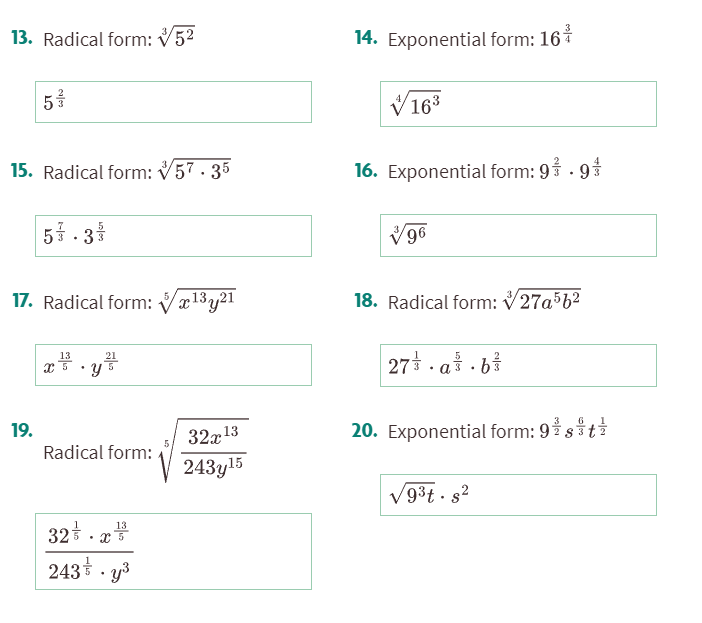

- intA = [2,3,4,5,6,7]
- intB = [2,3,4,5,6,7]
- intC = [2 to 25] 
- intD = [2 to 25] 
- intE = [2,3,4,5,6,7]
- intF = [2,3,4,5,6,7]
- intG = [2 to 25] 
- intH = [2 to 25] 
- charA = [ 'a','b','c','x','y','z']
- charB = [ 'a','b','c','x','y','z']
- charC = [ 'a','b','c','x','y','z']
- charD = [ 'a','b','c','x','y','z']
- charE = [ 'a','b','c','x','y','z']
--- 
case 1

$$ intA^{\frac{intC}{intB}} $$

---
case 2

$$ \sqrt[intB]{intA^{intC}} $$

--- 
case 3

$$ intA^{\frac{intB}{intC}} \cdot intE^{\frac{intF}{intC}} $$

---
case 4

$$ \sqrt[intA]{intB^{intC} \cdot intD^{intH}} $$

---
case 5

$$ intA^{\frac{intB}{intC}} \cdot intE^{\frac{intF}{intC}} $$

---
case 6

$$ \sqrt[intA]{ intG \cdot intB^{intC} \cdot intD^{intH}} $$

---

case 7

$$ intA^{\frac{intB}{intC}} \cdot intE^{\frac{intF}{intC}} \cdot charA^{\frac{charB}{intC}}$$

---
case 8

$$ \sqrt[intA]{ intG \cdot intB^{intC} \cdot intD^{intH}} $$

---
case 9

$$ \sqrt[intA]{ \frac{ intC \cdot charA^{intD} }{ intF \cdot charB^{intG} } }$$


In [ ]:
def notequal(inta, intb):
  while inta == intb:
      inta = randint(1, 25)
  return inta

def singlefraction(inta, intb, intc):
  return "$" + str(inta) + "^{\\frac{" + str(intc) + "}{" + str(intb) + "}}$"

def singlesqrt(inta, intb, intc):
  if intb == 2:
    return "$ \\sqrt{" +  str(inta) + "^{" + str(intc) +"}}$"
  else:
    return "$ \\sqrt[" + str(intb) + "]{" +  str(inta) + "^{" + str(intc) +"}}$"

def dualsqrt(inta, intb, intc, intd, inte):
  if inta == intb:
    if intc == 2:
      return "$ \\sqrt{" +  str(inta) + "^{" + str(intd + inte) +"}}$"
    else:
      return "$ \\sqrt[" + str(intc) + "]{" +  str(inta) + "^{" + str(intd + inte) +"}}$"
  else:
    if intc == 2:
      return "$ \\sqrt{" +  str(inta) + "^{" + str(intd) +"}*" +  str(intb) + "^{" + str(inte) +"}}$"
    else:
      return "$ \\sqrt[" + str(intc) + "]{" +  str(inta) + "^{" + str(intd) +"}*" +  str(intb) + "^{" + str(inte) +"}}$"

def trisqrt(inta, intb, intc, intd, inte, intf, intg):
  if inta == intb:
    if intd == 2:
      return "$ \\sqrt{" +  str(inta) + "^{" + str(intf + inte) +"}*" + str(intc) + "^{" + str(intg) +"}" + "}$"
    else:
      return "$ \\sqrt[" + str(intd) + "]{" +  str(inta) + "^{" + str(intf + inte) +"}*" + str(intc) + "^{" + str(intg) +"}" + "}$"
  else:
    if intd == 2:
      return "$ \\sqrt{" +  str(inta) + "^{" + str(inte) +"}*" +  str(intb) + "^{" + str(intf) +"}*" + str(intc) + "^{" + str(intg) +"}" + "}$"
    else:
      return "$ \\sqrt[" + str(intd) + "]{" +  str(inta) + "^{" + str(inte) +"}*" +  str(intb) + "^{" + str(intf) +"}*" + str(intc) + "^{" + str(intg) +"}" + "}$"
    
def radicalandfractionexponent(diff = 1, expr = "latex", form = "r"):
  if diff == 1: #single
    inta = randint(5, 250)
    intb = randint(2, 5)
    intc = intb
    intc = notequal(intc, intb)
    if form == "r":    
      problem = "Radical form " + singlesqrt(inta, intb, intc)
      answer = singlefraction(inta, intb, intc)
    else:
      problem = "Exponential form " + singlefraction(inta, intb, intc)
      answer = singlesqrt(inta, intb, intc)

  elif diff == 2: #dual
    inta = randint(3, 9)
    intb = randint(3, 9)
    intc = randint(2, 5)
    intd = intc
    intd = notequal(intd, intc)
    inte = intc
    inte = notequal(inte, intc)

    if form == "r":    
      problem = "Radical form " + dualsqrt(inta, intb, intc, intd, inte)
      answer = singlefraction(inta, intc, intd) + " * " + singlefraction(intb, intc, inte)
    else:
      problem = "Exponential form " + singlefraction(inta, intc, intd) + " * " + singlefraction(intb, intc, inte)
      answer = dualsqrt(inta, intb, intc, intd, inte)

  elif diff == 3: #tri
    fs = ["a", "b", "c", "d"]
    inta = randint(3, 9)
    intb = randint(3, 9)
    intc = fs[randint(0, 3)]
    intd = randint(2, 5)
    inte = intd
    intfe= notequal(inte, intd)
    intf = intd
    intf = notequal(intf, intd)
    intg = intd
    intg = notequal(intg, intd)

    if form == "r":    
      problem = "Radical form " + trisqrt(inta, intb, intc, intd, inte, intf, intg)
      answer = singlefraction(inta, intd, inte) + " * " + singlefraction(intb, intd, intf) + " * " + singlefraction(intc, intd, intg)
    else:
      problem = "Exponential form " + singlefraction(inta, intd, inte) + " * " + singlefraction(intb, intd, intf) + " * " + singlefraction(intc, intd, intg)
      answer = trisqrt(inta, intb, intc, intd, inte, intf, intg)

  return problem, answer

print(radicalandfractionexponent(3, "latex", "r"))

('Radical form $ \\sqrt[5]{9^{30}*c^{7}}$', '$9^{\\frac{5}{5}}$ * $9^{\\frac{25}{5}}$ * $c^{\\frac{7}{5}}$')


## AGS1.2.7.3 - X-intercept & Y-intercept

### instruction : Given the function, find the $x$-intercept(s) and $y$-intercept if they exist, and then use them to graph the function.
#### section 1

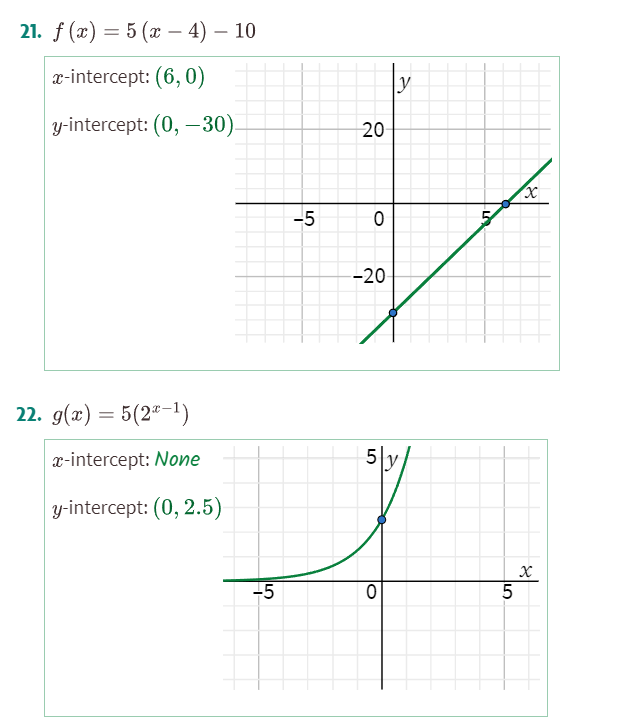

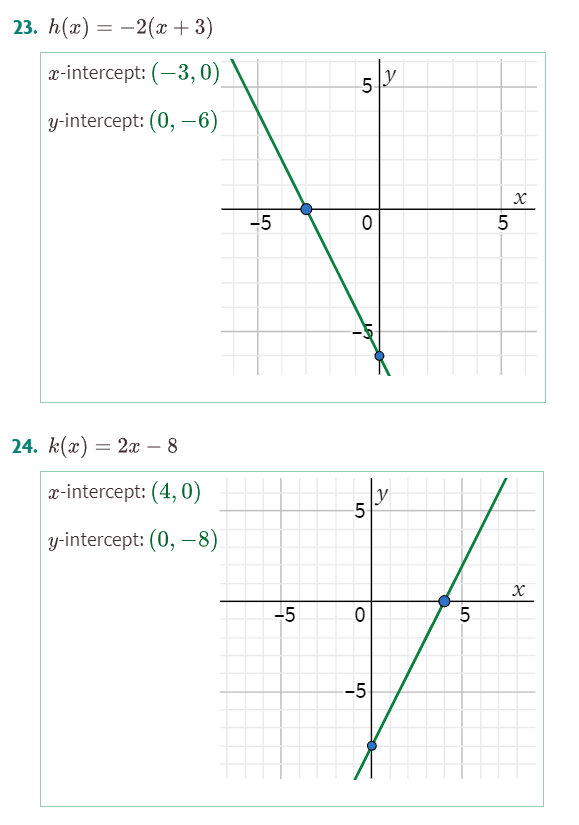

In [ ]:
from sympy import Symbol

def notzero(fnum, snum):
  inta = 0
  while inta == 0:
      inta = randint(fnum, snum)
  return inta

def setlinearequation(m, xint, yint):
  if yint >= 0:
    if xint > 0:
      equ = str(m) + "* (x + " + str(xint) + ") + " + str(yint)
    elif xint < 0:
      equ = str(m) + "* (x - " + str(xint) + ") + " + str(yint)
    else:
      equ = str(m) + "* x + "  + str(yint)
  else:
    if xint > 0:
      equ = str(m) + "* (x + " + str(xint) + ") " + str(yint)
    elif xint < 0:
      equ = str(m) + "* (x - " + str(xint) + ") " + str(yint)
    else:
      equ = str(m) + "* x "  + str(yint)

  return equ

def setexpequation(a, m, xint, yint):
  if yint > 0:
    if xint > 0:
      equ = str(a) + "*(" + str(m) + "^{x + " + str(xint) + "} + " + str(yint)
    elif xint < 0:
      equ = str(a) + "*(" + str(m) + "^{x " + str(xint) + "} + " + str(yint)
    else:
      equ = str(a) + "*(" + str(m) + "^{x} + " + str(yint)
  elif yint < 0:
    if xint > 0:
      equ = str(a) + "*(" + str(m) + "^{x + " + str(xint) + "} " + str(yint)
    elif xint < 0:
      equ = str(a) + "*(" + str(m) + "^{x " + str(xint) + "} " + str(yint)
    else:
      equ = str(a) + "*(" + str(m) + "^{x} " + str(yint)
  else:
    if xint > 0:
      equ = str(a) + "*(" + str(m) + "^{x + " + str(xint) + "}"
    elif xint < 0:
      equ = str(a) + "*(" + str(m) + "^{x " + str(xint) + "}"
    else:
      equ = str(a) + "*(" + str(m) + "^{x} "
  return equ

def createequation(equation, xint, yint, xintercept, yintercept, form):
  if xintercept != 0 and yintercept != 0:
    answer = "\\begin{minipage}[t]{0.5\\textwidth}\n\\begin{tikzpicture}\n\\begin{axis}\n[mmt axis style,xmin=-7,xmax=7,xtick={-5,0,...,11},ymin=-6,ymax=6,ytick={-10,-5,...,11},]\n"
    answer = answer + "\\addplot[red,domain=-10:10] {" + equation + "};\n"
    answer = answer + "\\fill[black] (axis cs: 0," + str("{:.2f}".format(yintercept)) + ") circle(2pt);\n"
    if form == 2 and xintercept == 0:
      answer = answer
    else:
      answer = answer + "\\fill[black] (axis cs:" + str("{:.2f}".format(xintercept)) + ", 0) circle(2pt);\n"
    answer = answer + "\\end{axis} \\end{tikzpicture} \\end{minipage}\n"
    answer = answer + "x-intercept: " + str("{:.2f}".format(xintercept)) + ", y-intercept: " + str("{:.2f}".format(yintercept))
  else:
    answer = "There is no x-intercept and y-intercept"
  return answer

def xinterceptyintercept(diff = 1, expr = "latex"):
  list = ["f", "g", "d", "u"]
  letter = list[randint(0, 3)]

  if diff == 1: #liner
    m = notzero(-3, 4)
    xint = randint(0, 5)
    yint = randint(-4, 4)
    equation = setlinearequation(m, xint, yint)
    xintercept = (-(m * xint) - yint) / m
    yintercept = (m * xint) + yint
    answer = createequation(equation, xint, yint, xintercept, yintercept, 1)
  elif diff == 2: #exp
    a = notzero(-3, 4)
    m = notzero(1, 4)
    xint = notzero(-2, 3)
    yint = randint(-2, 2)
    equation = setexpequation(a, m, xint, yint)
    answer = "{:.2f}".format(a * (m**(0-xint)) + yint) #Y-int

  return equation, answer

xinterceptyintercept(2)
 

('-1*(4^{x -1}', '-4.00')

Generate the empty grid from -9 to 9 

---
- intA = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
- intB = [2,3,4,5,6]
- intC = [0,1,2,3,4,5,6]
- intD = [-6,-5,-4,-3,-2,-1,2,3,4,5,6]
- intE = [2,3,4,5,6,7]
- intF = [2,3,4,5,6,7]
- intG = [2 to 25] 
- intH = [2 to 25] 
- charA = [ 'a','b','c','d','e','f']
--- 
case 1

slope = Rational(intA,intB)
$$ b(x) = slope * x $$

--- 
case 2

slope = Rational(intA,intB)
$$ a(x) = slope * (x \pm intB)$$

--- 
case 3

slope = Rational(intA,intB)
$$ f(x) = slope * (x \pm intB) \pm intC $$

--- 
case 4

$$ d(x) = intE * x \pm intB $$

--- 
case 5

$$ c(x) = intD* (x \pm intB)$$

--- 
case 6

$$ d(x) = intE * (x \pm intB) \pm intC $$




- $x$ intercept = ( , )
- $y$ intercept = ( , ) 
- empty graph:


#### section 2

Generate the empty grid from -7 to 7 

---
- intA = [-6,-5,-4,-3,-2,-1,1,2,3,4,5,6]
- intB = [2,3,4,5,6]
- intC = [2,3,4]
- intD = [2,3,4,5,6,7]
- intE = [-6,-5,-4,-3,-2,-1,2,3,4,5,6]
- intF = [2,3,4,5,6,7]
- intG = [2 to 25] 
- intH = [2 to 25] 
- charA = [ 'a','b','c','x','y','z']
- charB = [ 'a','b','c','x','y','z']
- charC = [ 'a','b','c','x','y','z']
- charD = [ 'a','b','c','x','y','z']
- charE = [ 'a','b','c','x','y','z']
--- 
case 1

$$ f(x) = intB * intC^{ x \pm intD } $$

--- 
case 2

$$ a(x) = intB * intC^{ x \pm intD } + intA $$

--- 
case 3

$$ b(x) = intE * intC^{ x \pm intD } + intA $$

--- 
case 4

commonratio= Rational(1,intC)
$$ c(x) = intB * (commonratio)^{ x \pm intD } $$

--- 
case 5

commonratio= Rational(1,intC)
$$ d(x) = intB * (commonratio)^{ x \pm intD } + intA $$

--- 
case 6

commonratio= Rational(1,intC)
$$ e(x) = intE * (commonratio)^{ x \pm intD } + intA $$



In [ ]:
def GraphXintYint_2_7_3(kind='lin', expr='latex'):
    case = randint(1,6)
    if kind == 'lin':
        if case == 1:
            slope, pt = Rational(getInt(-6,6),randint(2,6)), [0, 0]
        elif case == 2:
            slope, pt = Rational(getInt(-6,6),randint(2,6)), [getInt(-6,6), 0]
        elif case == 3:
            slope, pt = Rational(getInt(-6,6),randint(2,6)), [getInt(-6,6), randint(-6,6)]
        elif case == 4:
            slope, pt = getInt(-6,6), [0, getInt(-6,6)]
        elif case == 5:
            slope, pt = getInt(-6,6), [getInt(-6,6), 0]
        elif case == 6:
            slope, pt = getInt(-6,6), [getInt(-6,6), randint(-6,6)]

        func = LinFunc(slope, pt)
    elif kind == 'exp':
        if case == 1:
            base, pt, shift = randint(2,4), [getInt(-6,6), getInt(2,6)], 0
        elif case == 2:
            base, pt, shift = randint(2,4), [getInt(-6,6), getInt(2,6)], getInt(-6,6)
        elif case == 3:
            base, pt, shift = randint(2,4), [getInt(-6,6), getInt(-6,6)], getInt(-6,6)
        elif case == 4:
            base, pt, shift = Rational(1,randint(2,4)), [getInt(-6,6), getInt(2,6)], 0
        elif case == 5:
            base, pt, shift = Rational(1,randint(2,4)), [getInt(-6,6), getInt(2,6)], getInt(-6,6)
        elif case == 6:
            base, pt, shift = Rational(1,randint(2,4)), [getInt(-6,6), getInt(-6,6)], getInt(-6,6)
    
        func = ExpFunc(base, pt, shift=shift)

    problem = signify(func.getPtSlope(pt[0])) if kind=='lin' else signify(func.getPtBase(pt[0]))
    problem += r' \newline $y$-intercept: $(\quad, \quad)$ \newline '
    problem += r'$x$-intercept: $(\quad, \quad)$ \newline '
    problem += emptyGraph()

    xint = func.solve(0)
    xint = xint if type(xint) in [Integer,Rational] else N(xint,3)

    answer = fr'$y$-intercept = $(0,{latexify(func.intercept)})$ \newline $x$-intercept: '
    answer += fr'$({latexify(xint)}, 0)$ \newline ' if xint!=None else r'None \newline '
    answer += startGraph() + drawCurve(func.expr,-10,10) + drawPt([0,N(func.intercept,3)])
    answer += (drawPt([xint,0]) + endGraph()) if xint!=None else endGraph()

    return problem, answer

for jj in range(5):
    problem, answer = GraphXintYint_2_7_3(kind='exp')
    print(problem)
    print(answer)

$f(x) = -5\left(\frac{1}{2}\right)^{x + 1}+3$ \newline $y$-intercept: $(\quad, \quad)$ \newline $x$-intercept: $(\quad, \quad)$ \newline \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\end{axis}\end{tikzpicture}
$y$-intercept = $(0,\frac{1}{2})$ \newline $x$-intercept: $(-0.26, 0)$ \newline \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\addplot[black,solid,thick,domain=-10:10,samples=100] {3 - 5*2^(-x)/2};\fill[draw=black,fill=black] (axis cs: 0,0.500) circle(2pt);\fill[draw=black,fill=black] (axis cs: -0.263,0) circle(2pt);\end{axis}\end{tikzpicture}
$f(x) = 7 \cdot 4^{x + 2}-4$ \newline $y$-intercept: $(\quad, \quad)$ \newline $x$-intercept: $(\quad, \quad)$ \newline \begin{tikzpicture}\begin{axis}[mmt axis style,xmin=-10,xmax=10,xtick={-10,-5,...,15},ymin=-10,ymax=10,ytick={-10,-5,...,15},]\end{axis}\end{tikzpicture}
$y$-inter

## AGS1.2.8.1 - Fill In The Missing Numbers As Arithmetic & Geometric Sequence

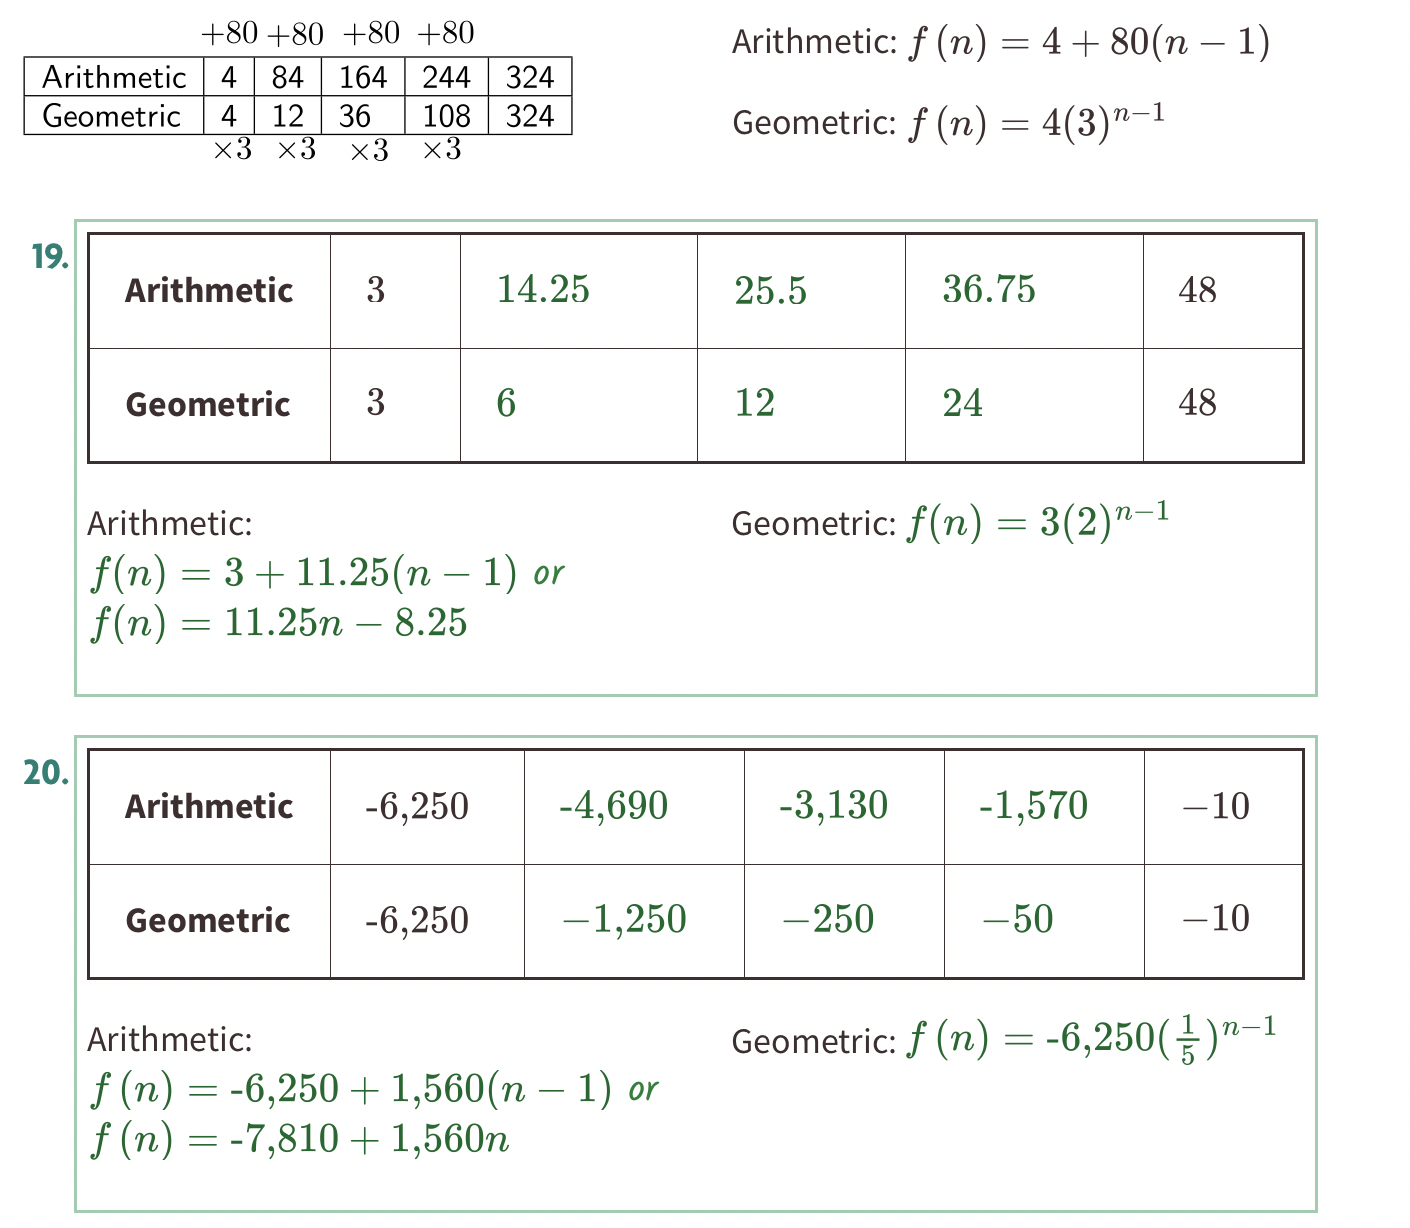

### Section 1
#### instruction : The first and fifth terms of a sequence are given. Fill in the missing numbers if it is an arithmetic sequence. Then fill in the numbers if it is a geometric sequence. Write the explicit rule for each function.




Generate geometric sequence 5 numbers display numbers
Arithmetic sequence 5 numbers disp

###Case 1: growth ( postivie 1st or negative 1st )
---

| Arithmetic | 3 | __ | __ | __ | 48 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Geometric | 3 | __ | __ | __ | 48 |

- Arithmetic :

- Geometric  :

---
answer :

| Arithmetic | 3 | 14.25 | 25.5 | 36.75 | 48 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Geometric | 3 | 6 | 12 | 24 | 48 |

- Arithmetic : $ f(n) = 3 + 11.25(n-1)$ or $f(n) = 11.25n-8.25$

- Geometric  : $ f(n) = 3(2)^{n-1}$

Case 2: decay ( postivie 1st or negative 1st )
---

| Arithmetic | -6,250 | ___ | ___ | ___ | -10 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Geometric | -6,250 | ___ | ___ | ___ | -10 |

- Arithmetic :

- Geometric  :

---
answer :

| Arithmetic | -6,250 | -4,690 | -3,130 | -1,570 | -10 |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Geometric | -6,250 | -1,250 | -250 | -50 | -10 |

- Arithmetic : $ f(n) = -6250 + 1560 (n-1)$ or $f(n) = -7810 + 1560n$

- Geometric  : $ f(n) = -6250(\frac{1}{5})^{n-1}$






In [ ]:
def FillInTheMeansTable(expr='latex'):
    ratio = randint(2,7)
    start = getInt(-9,9)
    geo = GeoSeq(ratio,[1,start])
    geoterms = latexify(geo.getTerms(5))
    end = geo.findTerm(5)

    row = [signify(geoterms[1]), r'\phantom{$' + geoterms[2] + r'$}', r'\phantom{$' + geoterms[3] + r'$}', r'\phantom{$' + geoterms[4] + r'$}', signify(geoterms[5])]
    header = ['Arithmetic'] + row
    row = ['Geometric'] + row
    
    if randint(0,1):
        problem = tableGenerator(header, [row])
        row[2:5] = [signify(geoterms[2]), signify(geoterms[3]), signify(geoterms[4])]

        arith = ArithSeq.fromPts([1,start],[5,end],variable=n)
    else:
        header[1:] = header[:0:-1]
        row[1:] = row[:0:-1]
        problem = tableGenerator(header, [row])
        row[2:5] = [signify(geoterms[4]), signify(geoterms[3]), signify(geoterms[2])]
        
        geo = GeoSeq.fromPts([1,end],[5,start],variable=n)
        arith = ArithSeq.fromPts([1,end],[5,start],variable=n)

    arithterms = latexify(arith.getTerms(4))
    header[2:5] = [signify(arithterms[2]), signify(arithterms[3]), signify(arithterms[4])]
    answer = tableGenerator(header, [row])
    if expr=='latex':
        answer += r'\newline ' + signify(arith.getExplicit()) + r'\newline '
        answer += signify(geo.getExplicit())
    else:
        answer = [answer, arith, geo]

    return problem, answer

for jj in range(5):
    problem, answer = FillInTheMeansTable()
    print(problem)
    print(answer)

{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|c|c|c|c|}
			\hline
			Arithmetic & $-5$ & \phantom{$-10$} & \phantom{$-20$} & \phantom{$-40$} & $-80$ \\
			\hline
			Geometric & $-5$ & \phantom{$-10$} & \phantom{$-20$} & \phantom{$-40$} & $-80$ \\
			\hline
		\end{tabular}
	\end{center}}
{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|c|c|c|c|}
			\hline
			Arithmetic & $-5$ & $- \frac{95}{4}$ & $- \frac{85}{2}$ & $- \frac{245}{4}$ & $-80$ \\
			\hline
			Geometric & $-5$ & $-10$ & $-20$ & $-40$ & $-80$ \\
			\hline
		\end{tabular}
	\end{center}}\newline $f(n) = - \frac{75}{4}\left(n-1\right)-5$\newline $f(n) = -5 \cdot 2^{n - 1}$
{\renewcommand{\arraystretch}{1.5}	\begin{center}
		\begin{tabular}{|c|c|c|c|c|c|}
			\hline
			Arithmetic & $4$ & \phantom{$20$} & \phantom{$100$} & \phantom{$500$} & $2,500$ \\
			\hline
			Geometric & $4$ & \phantom{$20$} & \phantom{$100$} & \phantom{$500$} & $2,500$ \\
			\hline
		\end{tabular}
	\end{cent

## AGS1.2.10.1 - Slope-Intercept / Point-Slope Form

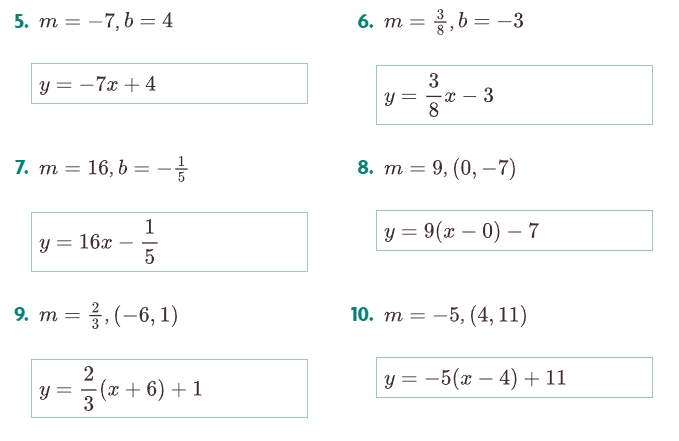

### instruction : Use the given information to create an explicit equation. Your explicit equation should be in either slope-intercept ($y=mx+b $) or point-slope form ($y = m(x-x_1)+y_1 $). Use the form that is most efficient based on the given information.

#### section 1

Case 1:
- $m = -7,b=4$

- Equation : 

- answer :  $ y = -7x+4 $

- $m=\frac{3}{8} , b = -3$

- Equation : 

- answer :  $ y = \frac{3}{8}x-3 $

---

Case 2:
- $m = 9 , (0,-7) $

- Equation : 

- answer :  $ y = 9(x-0) -7 $

 
- $m = -5 , (4,11) $

- Equation : 

- answer :  $ y = -5(x-4) +11 $

In [ ]:
def LinearForms_2_10_1(case=1, expr='latex'):
    func = LinFunc(getInt(-9,9), getInt(-9,9))
    if case == 1: # slope and point
        problem = fr'$m = {latexify(func.slope)},\quad '
        if randint(0,1): # from intercept
            problem += fr'b = {latexify(func.intercept)}$'
            answer = signify(func.getSlopeInt())
        else: # from point
            pt = getInt(-9,9)
            answer = signify(func.getPtSlope(pt))

            pt = [latexify(pt), latexify(func.subs(pt))]
            problem += fr'({pt[0]},{pt[1]})$'
    else: # from table
        problem = func.getTable([32,33,34,35],labels=['$x$','$y$'])
        answer = signify(func.getSlopeInt() + r',\quad ' + func.getPtSlope(33))

    return problem, answer

for jj in range(10):
    problem, answer = LinearForms_2_10_1()
    print(problem, r'\\')
    print(answer, r'\\')

### section 2
#### instruction : For each table of values, write two different explicit equations in point-slope form and slope-intercept form.

Case 1:

| x | y |
| :---: | :---: |
| 32 | 17 |
| 33 | 11 |
| 34 | 5 |
| 35 | -1 |

- Point Slope Form : 
- Slopet Intercept Form : 


In [ ]:
for jj in range(10):
    problem, answer = LinearForms_2_10_1(case=2)
    print(problem, r'\\')
    print(answer, r'\\')

NameError: ignored

## AGS1.2.10.2 - Justification ( HOLD just brainstorm)


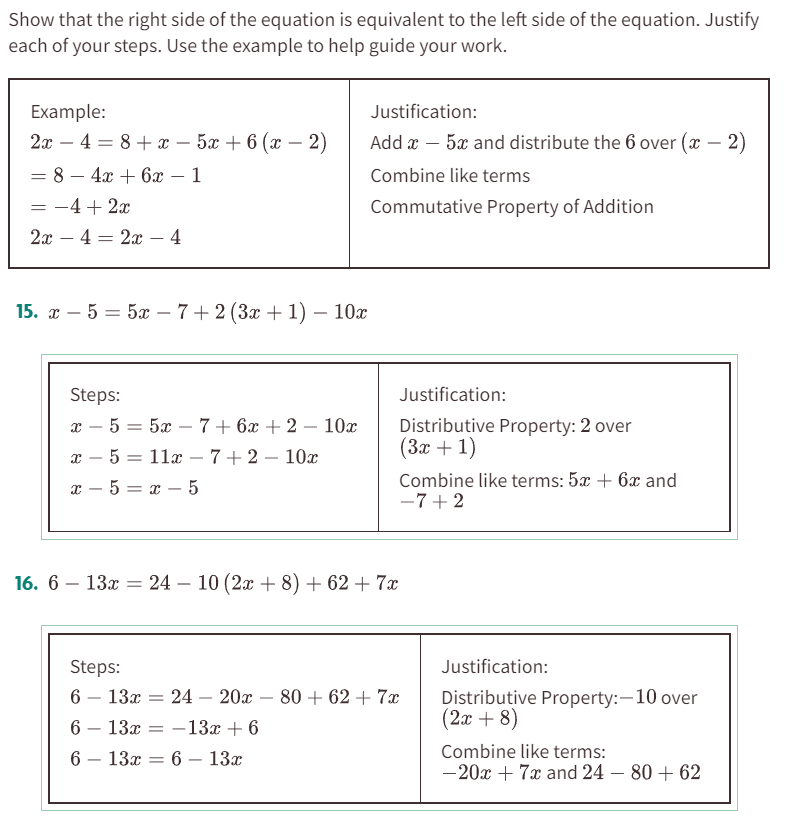

### section 2 - from lesson 11

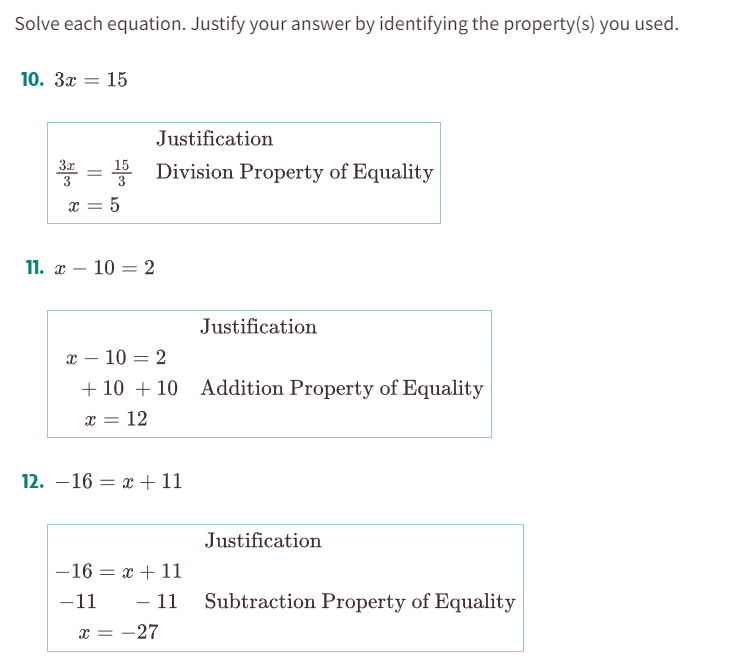

## AGS1.2.11.1 - Compare Different Characteristics

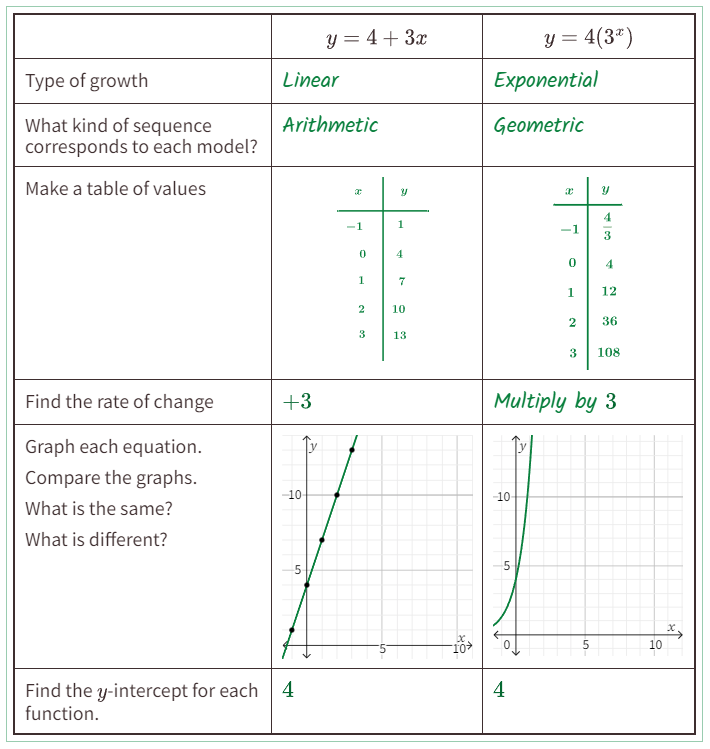

#### instruction : Compare different characteristics of each type of function by filling in the cells of each table as completely as possible.




In [ ]:
from sympy import *

def notzero(min, max):
  inta = 0
  while inta == 0:
    inta = randint(min, max)
  return inta

def getyval(equation, xtable=[]):
  x = Symbol('x')
  ytable = []
  for i in xtable:
    ytable.append(equation.subs(x, i))
  return ytable

def creategraph(equation=0, point1=[], point2=[], form=0):
  if form == 0: #linear equation
    answer = "\\begin{minipage}[t]{0.5\\textwidth}\n\\begin{tikzpicture}\n\\begin{axis}\n[mmt axis style,xmin=-1,xmax=4,xtick={-5,0,...,11},ymin=-1,ymax=15,ytick={-10,-5,...,15},]\n"
    answer = answer + "\\addplot[red,domain=-5:5] {" + str(equation) + "};\n"

  elif form == 1:
    answer = "\\begin{minipage}[t]{0.5\\textwidth}\n\\begin{tikzpicture}\n\\begin{axis}\n[mmt axis style,xmin=-1,xmax=4,xtick={-5,0,...,11},ymin=-1,ymax=15,ytick={-10,-5,...,15},]\n"
    answer = answer + "\\addplot[red,domain=-5:5] {" + str(equation) + "};\n"

  answer = answer + "\\fill[black] (axis cs:" + str(point1[0]) + "," + str(point1[1]) + ") circle(2pt);\n"
  answer = answer + "\\fill[black] (axis cs:" + str(point2[0]) + "," + str(point2[1]) + ") circle(2pt);\n"
  answer = answer + "\\end{axis} \\end{tikzpicture} \\end{minipage}"
  return answer

def setlinearequation(m, xint, yint):
  if yint >= 0:
    if xint > 0:
      equ = str(m) + "* (x + " + str(xint) + ") + " + str(yint)
    elif xint < 0:
      equ = str(m) + "* (x " + str(xint) + ") + " + str(yint)
    else:
      equ = str(m) + "* x + "  + str(yint)
  else:
    if xint > 0:
      equ = str(m) + "* (x + " + str(xint) + ") " + str(yint)
    elif xint < 0:
      equ = str(m) + "* (x " + str(xint) + ") " + str(yint)
    else:
      equ = str(m) + "* x "  + str(yint)

  return equ
  
def setexpequation(a, m, xint, yint):
  if yint > 0:
    if xint > 0:
      equ = str(a) + "*(" + str(m) + "^{x + " + str(xint) + "}) + " + str(yint)
    elif xint < 0:
      equ = str(a) + "*(" + str(m) + "^{x " + str(xint) + "}) + " + str(yint)
    else:
      equ = str(a) + "*(" + str(m) + "^{x}) + " + str(yint)
  elif yint < 0:
    if xint > 0:
      equ = str(a) + "*(" + str(m) + "^{x + " + str(xint) + "}) " + str(yint)
    elif xint < 0:
      equ = str(a) + "*(" + str(m) + "^{x " + str(xint) + "}) " + str(yint)
    else:
      equ = str(a) + "*(" + str(m) + "^{x}) " + str(yint)
  else:
    if xint > 0:
      equ = str(a) + "*(" + str(m) + "^{x + " + str(xint) + "})"
    elif xint < 0:
      equ = str(a) + "*(" + str(m) + "^{x " + str(xint) + "})"
    else:
      equ = str(a) + "*(" + str(m) + "^{x}) "
  return equ

def createproblem(equation):
  problem = "\\begin{center} \n \\begin{tabular}{|l|c|} \\hline \n"
  problem = problem + "$ $ & $" + str(equation) + "$ \\\\ \\hline" + " \n "
  problem = problem + r"Type of growth & $ $ \\ \hline" + "\n"
  problem = problem + r"\pbox{20cm}{What kind of sequence \\ corresponds to each model?} & $ $ \\ \hline" + "\n"
  problem = problem + r"Make a table of values & \begin{tabular}{c|c} \hline $x$ & $y$\\ \hline -1 & $ $ \\ \hline 0 & $ $ \\ \hline 1 & $ $ \\ \hline 2 & $ $ \\ \hline 3 & $ $ \\ \end{tabular} \\ \hline" + "\n"
  problem = problem + r"Find the rate of change & $ $ \\ \hline" + "\n" 
  problem = problem + r"\pbox{20cm}{Graph each equation. \\ Compare the graphs. \\ What is the same? \\ What is different?} &"
  problem = problem + r"[t]{0.5\textwidth}" + "\n" + r"\begin{tikzpicture}\begin{axis} [mmt axis style,xmin=-1,xmax=5,xtick={-5,0,...,11},ymin=-1,ymax=15,ytick={-10,-5,...,15},]" + "\n" + r"\end{axis} \end{tikzpicture} \\ \hline" + "\n"
  problem = problem + r" Find the y-intercept for each function. & $ $" + r"\\ \hline" + "\n" + r"\end{tabular}\end{center}"

  return problem

def createanswer(equation=0, growth=0, model=0, yint=[], rate=0, graph=0, inty=0):
  problem = "\\begin{center} \n \\begin{tabular}{|l|c|} \\hline \n "
  problem = problem + r"$ $ & $" + str(equation) + r"$ \\ \hline" + " \n "
  problem = problem + r"Type of growth & $ " + growth + " $ \\\\ \hline" + "\n "
  problem = problem + r"\pbox{20cm}{What kind of sequence \\ corresponds to each model?} & $ " + model + r" $ \\ \hline" + "\n "
  problem = problem + r"Make a table of values & \begin{tabular}{c|c} \hline $x$ & $y$\\ \hline -1 & $ " + str(yint[0])
  problem = problem + r" $ \\ \hline 0 & $ " + str(yint[1])
  problem = problem + r" $ \\ \hline 1 & $ " + str(yint[2])
  problem = problem + r" $ \\ \hline 2 & $ " + str(yint[3])
  problem = problem + r" $ \\ \hline 3 & $ " + str(yint[4]) + r" $ \\ \end{tabular} \\ \hline" + "\n "
  problem = problem + r"Find the rate of change & $ " + str(rate) + r" $ \\ \hline" + "\n " 
  problem = problem + r"\pbox{20cm}{Graph each equation. \\ Compare the graphs. \\ What is the same? \\ What is different?} & " + graph + r"\\ \hline " + "\n "
  problem = problem + r"Find the y-intercept for each function. & $ " + str(inty) + r" $ \\ \hline" + "\n" + r"\end{tabular}\end{center}"

  return problem

def comparedifferent(diff = 1, expr="latex"):
  xtable = [-1, 0, 1, 2, 3]
  if diff == 1: #linear
    x = Symbol('x')
    a = notzero(-8, 8)
    b = notzero(-2, 10)
    xint = randint(-3, 5)
    equation = setlinearequation(a, xint, b)
    ytable = getyval(a * (x+xint) + b, xtable)
    graph = creategraph(equation, [ xtable[1], ytable[1] ],[ xtable[3], ytable[3] ], 0)
    yintercept = (a * xint) + b

    return createproblem(equation), createanswer(equation, "Linear", "Arithmetic", ytable, a, graph, yintercept)
  elif diff == 2: #quadratic
    x = Symbol('x')
    a = notzero(-3, 4)
    m = notzero(1, 4)
    xint = notzero(-2, 2)
    yint = randint(-2, 2)
    equation = setexpequation(a, m, xint, yint)
    ytable = getyval((a * (m**(x+xint))+yint), xtable)
    graph = creategraph(str(a)+"*+pow("+str(m)+","+str(x)+"+"+str(xint)+")+"+str(yint), [ xtable[1], ytable[1] ],[ xtable[3], ytable[3] ], 1)

    return createproblem(equation), createanswer(equation, "Exponential", "Geometric", ytable, m, graph, ytable[1])